In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_c = pd.read_csv(r'C:\Users\kesav\Guvi\guvi main\capstone4\Copper_Set.xlsx - Result 1.csv', low_memory=False)
df_c.head(2)

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.15113862,30156308.0,28.0,Won,W,10.0,2.0,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.0
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.0248392,30202938.0,25.0,Won,W,41.0,0.8,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.0


In [3]:
cu=df_c.copy()
cu.head(2)

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.15113862,30156308.0,28.0,Won,W,10.0,2.0,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.0
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.0248392,30202938.0,25.0,Won,W,41.0,0.8,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.0


In [4]:
cu.isnull().sum().sort_values(ascending=False)

material_ref     77919
country             28
application         24
id                   2
status               2
item_date            1
customer             1
thickness            1
delivery date        1
selling_price        1
quantity tons        0
item type            0
width                0
product_ref          0
dtype: int64

In [5]:
def unique_value(df):       
    columns=list(df.columns)
    for i in columns:
            unique=len(cu[i].unique())
            print(f"{i}:{unique}")

In [6]:
unique_value(cu)

id:181672
item_date:253
quantity tons:181673
customer:1170
country:18
status:10
item type:7
application:31
thickness:595
width:1386
material_ref:16564
product_ref:33
delivery date:29
selling_price:9796


1.All values in the ID column are unique so it is not going to help to predict target value.
2.Material reference is a categorical value and it has many null values and also many unique values which is not going to help to predict the selling price.
We drop this two columns from the data frame.
3.The null values of other columns are very low so we are going to drop that values.

In [7]:
cu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity tons  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB


In [8]:
cu['item_date'] = pd.to_datetime(cu['item_date'], format='%Y%m%d', errors='coerce')
cu['delivery date'] = pd.to_datetime(cu['delivery date'], format='%Y%m%d', errors='coerce')
cu['quantity tons'] = pd.to_numeric(cu['quantity tons'], errors='coerce')

In [9]:
cu.drop(columns=['id','material_ref'], inplace=True)

In [10]:
cu=cu.dropna()

In [11]:
invalid_delivery_dates = cu[cu['delivery date'] <= cu['item_date']]
invalid_delivery_dates.shape

(16567, 12)

Nearly 10% of delivery date are inconsistent we try to replace that date

In [12]:
cu

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,delivery date,selling_price
0,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,2021-07-01,854.00
1,2021-04-01,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,2021-04-01,1047.00
2,2021-04-01,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,2021-01-01,644.33
3,2021-04-01,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,2021-01-01,768.00
4,2021-04-01,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,2021-03-01,577.00
...,...,...,...,...,...,...,...,...,...,...,...,...
181668,2020-07-02,102.482422,30200854.0,25.0,Won,W,41.0,0.96,1220.0,164141591,2020-07-01,591.00
181669,2020-07-02,208.086469,30200854.0,25.0,Won,W,41.0,0.95,1500.0,164141591,2020-07-01,589.00
181670,2020-07-02,4.235594,30200854.0,25.0,Won,W,41.0,0.71,1250.0,164141591,2020-07-01,619.00
181671,2020-07-02,-2000.000000,30200854.0,25.0,Won,W,41.0,0.85,1250.0,164141591,2020-07-01,601.00


In [13]:
mask = cu['delivery date'] <= cu['item_date']
cu.loc[mask, 'delivery date'] = cu.loc[mask, 'item_date'] + pd.DateOffset(days=2)


In [14]:
invalid_delivery_dates = cu[cu['delivery date'] <= cu['item_date']]
invalid_delivery_dates.shape

(0, 12)

In [15]:
cu.head()

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,delivery date,selling_price
0,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,2021-07-01,854.00
1,2021-04-01,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,2021-04-03,1047.00
2,2021-04-01,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,2021-04-03,644.33
3,2021-04-01,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,2021-04-03,768.00
4,2021-04-01,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,2021-04-03,577.00


In [16]:
cu_1=cu.copy()

In [17]:
cu_1.describe().T

,count,mean,min,25%,50%,75%,max,std
item_date,181633,2020-11-26 23:03:18.855934720,2020-07-02 00:00:00,2020-09-29 00:00:00,2020-11-30 00:00:00,2021-02-03 00:00:00,2021-04-01 00:00:00,NaN
quantity tons,181633.0,5876.166536,-2000.0,10.968192,30.36258,67.161454,1000000000.0,2349333.423822
customer,181633.0,30232505.288868,12458.0,30196884.0,30205242.0,30280416.0,30408185.0,100562.109391
country,181633.0,44.89301,25.0,26.0,30.0,78.0,113.0,24.404237
application,181633.0,25.616072,2.0,10.0,15.0,41.0,99.0,17.753933
thickness,181633.0,2.56419,0.18,0.7,1.5,3.0,2500.0,6.572602
width,181633.0,1295.263685,1.0,1180.0,1250.0,1500.0,2990.0,261.644745
product_ref,181633.0,474034556.504259,611728.0,611993.0,640665.0,1332077137.0,1722207579.0,717540323.716319
delivery date,181633,2021-01-28 04:53:56.002268672,2020-07-04 00:00:00,2020-11-01 00:00:00,2021-01-17 00:00:00,2021-04-01 00:00:00,2022-01-01 00:00:00,NaN
selling_price,181633.0,1918.355312,-1160.0,669.0,812.0,953.0,100001015.0,331831.261428


In [18]:
mapping = {
    '1': ['Won'],
    '2': ['Draft', 'To be approved', 'Lost', 'Not lost for AM', 'Revised', 'Offered', 'Offerable','Wonderful']
}
def map_categories(status):
    for key, values in mapping.items():
        if status in values:
            return key
    return status

# Apply mapping to the 'status' column
cu_1['status'] = cu_1['status'].apply(map_categories)

In [19]:
cu_1['status'].unique()

array(['1', '2'], dtype=object)

In [20]:
cu_1['status'] = OrdinalEncoder().fit_transform(cu_1[['status']])

In [21]:
cu_1['status'].unique()

array([0., 1.])

0.0 is WON
1.0 IS LOSS

In [22]:
cu_1['status'].unique()

array([0., 1.])

In [23]:
cu_1['item type'].unique()

array(['W', 'WI', 'S', 'Others', 'PL', 'IPL', 'SLAWR'], dtype=object)

In [24]:
len(cu_1['item type'].unique())

7

In [25]:
cu_1['item type'] = OrdinalEncoder().fit_transform(cu_1[['item type']])

In [26]:
cu_1['item type'].unique()

array([5., 6., 3., 1., 2., 0., 4.])

'W'=5., 'WI'=6., 'S'=3., 'Others'=1., 'PL'=2., 'IPL'=0., 'SLAWR'=4.

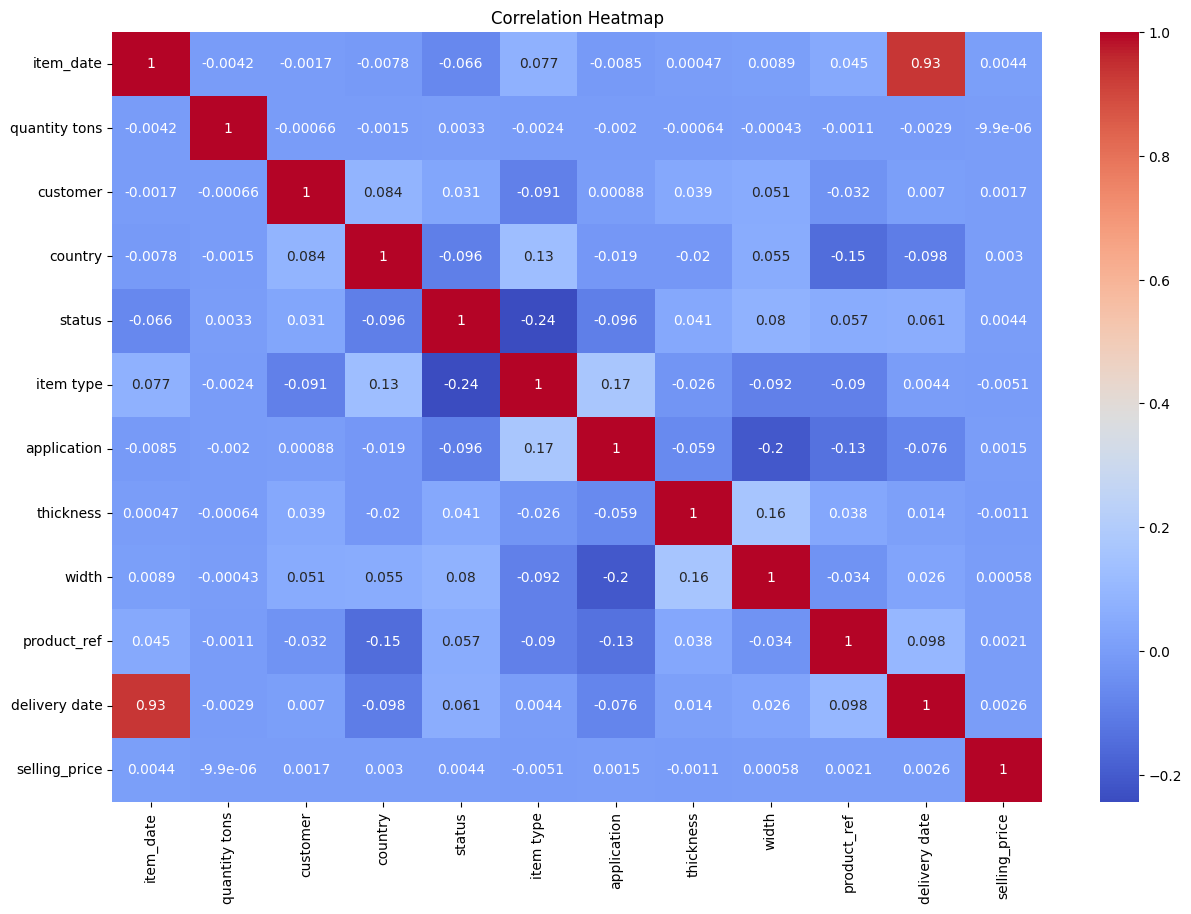

In [28]:
plt.figure(figsize=(15, 10))
sns.heatmap(cu_1.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [30]:
def plot(df,i):
    sns.histplot(df[i], kde=True, color='skyblue', bins=30)
    plt.show()

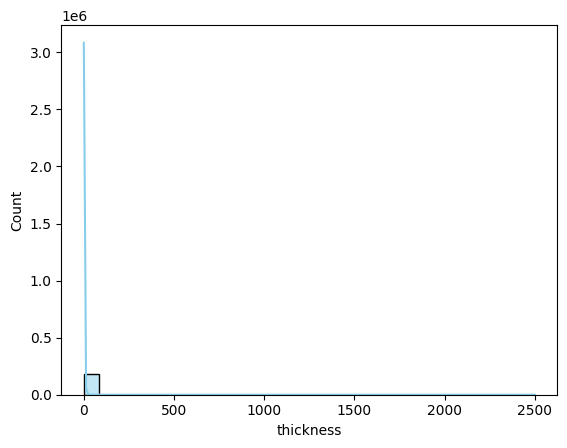

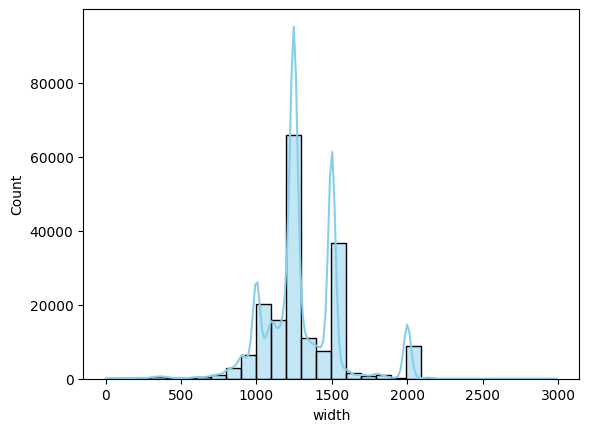

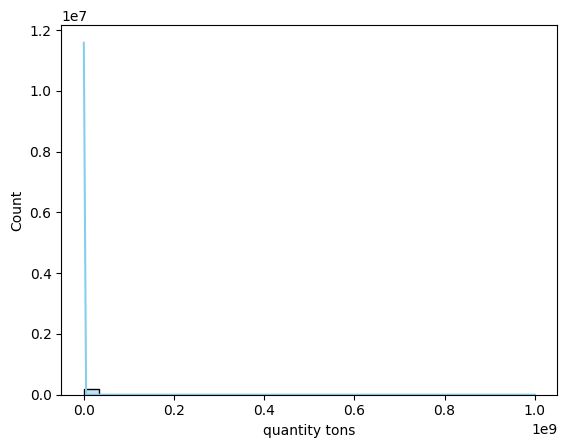

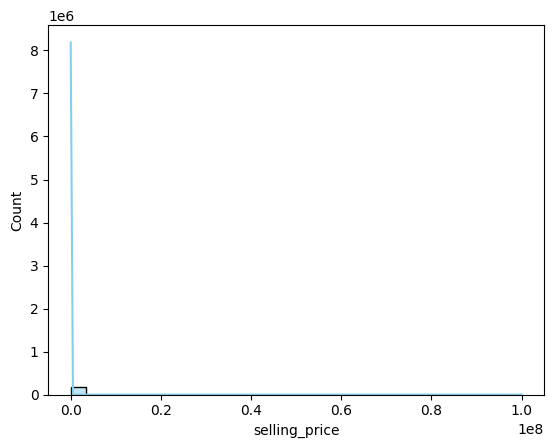

In [31]:
c1=['thickness','width','quantity tons','selling_price']
for i in c1:
    plot(cu,i)

In [29]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [32]:
numeric_cols=['quantity tons','thickness', 'width', 'selling_price']
for column in numeric_cols:
    cu_1 = remove_outliers_iqr(cu_1, column)

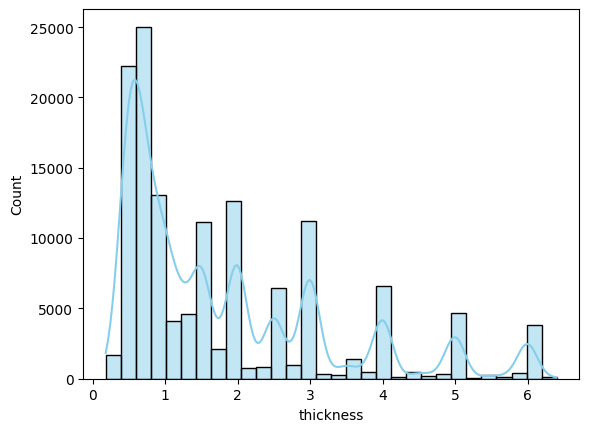

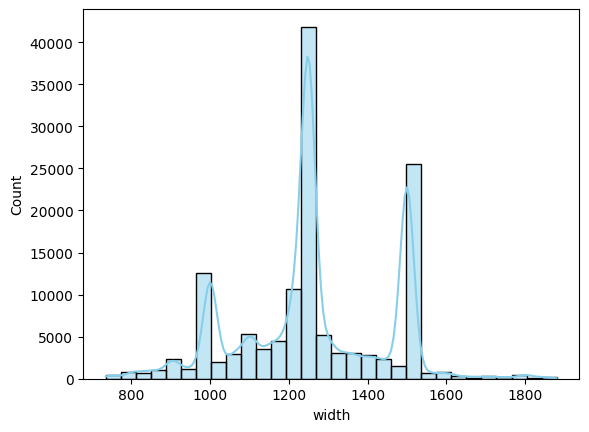

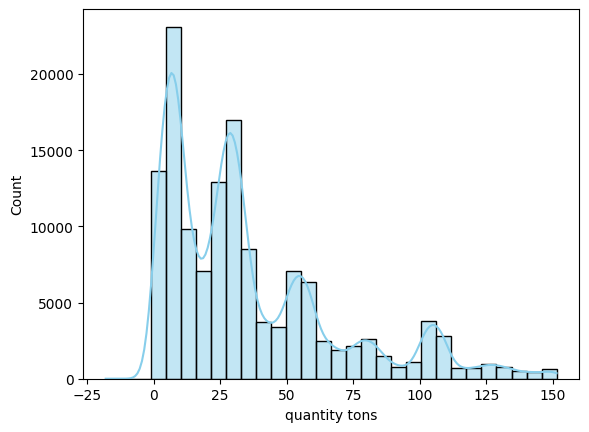

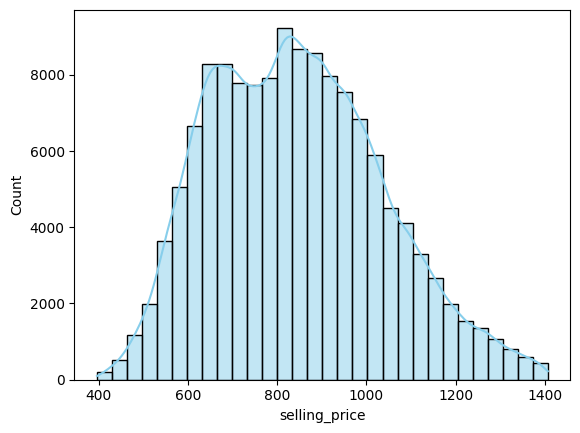

In [34]:
c1=['thickness','width','quantity tons','selling_price']
for i in c1:
    plot(cu_1,i)

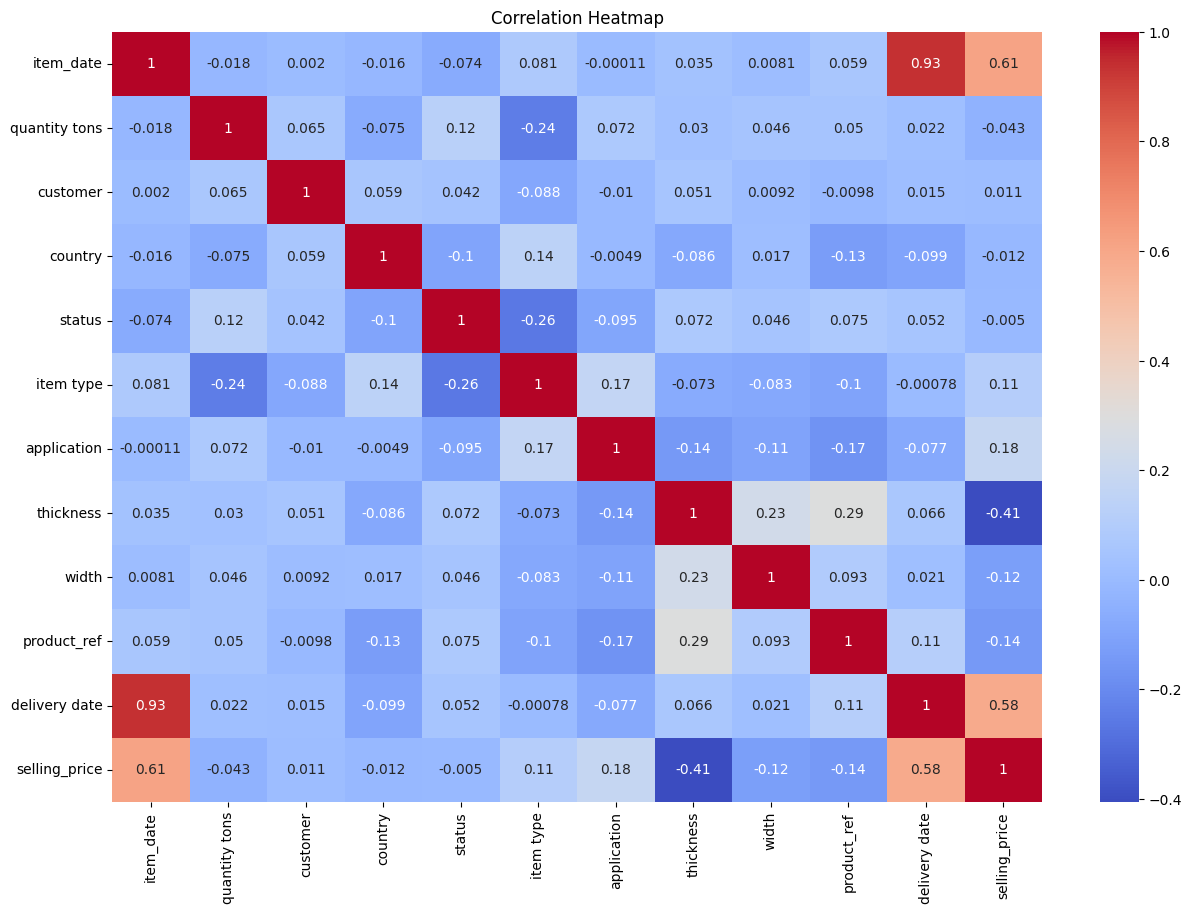

In [35]:
plt.figure(figsize=(15, 10))
sns.heatmap(cu_1.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [36]:
cu_1.describe().T

,count,mean,min,25%,50%,75%,max,std
item_date,136394,2020-11-26 03:39:27.711190016,2020-07-02 00:00:00,2020-09-29 00:00:00,2020-11-27 00:00:00,2021-02-02 00:00:00,2021-04-01 00:00:00,NaN
quantity tons,136394.0,36.13219,-18.0,9.576383,27.704875,52.32165,151.450064,32.844795
customer,136394.0,30229156.874577,12458.0,30165716.0,30204967.0,30272192.0,30408185.0,107841.593677
country,136394.0,45.377451,25.0,26.0,30.0,78.0,113.0,24.636862
status,136394.0,0.332317,0.0,0.0,0.0,1.0,1.0,0.471046
item type,136394.0,4.202648,0.0,3.0,5.0,5.0,6.0,1.022382
application,136394.0,25.68462,2.0,10.0,15.0,41.0,99.0,17.606108
thickness,136394.0,1.800205,0.18,0.68,1.25,2.5,6.4,1.444781
width,136394.0,1258.89578,735.0,1164.0,1250.0,1400.0,1880.0,184.330574
product_ref,136394.0,481033119.9071,611733.0,611993.0,640665.0,1332077137.0,1721130331.0,714533724.574274


In [37]:
cu_1['i_day']=cu_1['item_date'].dt.day
cu_1['i_month'] = cu_1['item_date'].dt.month
cu_1['i_year'] = cu_1['item_date'].dt.year
cu_1['d_day']=cu_1['delivery date'].dt.day
cu_1['d_month'] = cu_1['delivery date'].dt.month
cu_1['d_year'] = cu_1['delivery date'].dt.year

In [38]:
last_c=cu_1.pop('selling_price')
cu_1.insert(len(cu_1.columns),'selling_price',last_c)

In [39]:
cu_1.isnull().sum()

item_date        0
quantity tons    0
customer         0
country          0
status           0
item type        0
application      0
thickness        0
width            0
product_ref      0
delivery date    0
i_day            0
i_month          0
i_year           0
d_day            0
d_month          0
d_year           0
selling_price    0
dtype: int64

In [40]:
cu_2=cu_1.copy()

In [42]:
cu_2.columns

Index(['item_date', 'quantity tons', 'customer', 'country', 'status',
       'item type', 'application', 'thickness', 'width', 'product_ref',
       'delivery date', 'i_day', 'i_month', 'i_year', 'd_day', 'd_month',
       'd_year', 'selling_price'],
      dtype='object')

In [43]:
cu_2 = cu_2.drop(['item_date','delivery date'], axis=1)

In [44]:
cu_2.columns

Index(['quantity tons', 'customer', 'country', 'status', 'item type',
       'application', 'thickness', 'width', 'product_ref', 'i_day', 'i_month',
       'i_year', 'd_day', 'd_month', 'd_year', 'selling_price'],
      dtype='object')

In [45]:
feature_r=cu_2[[ 'quantity tons', 'customer', 'country', 'status',
       'item type', 'application', 'thickness', 'width', 'product_ref','i_day', 'i_month', 'i_year', 'd_day', 'd_month',
       'd_year']]
target_r=cu_2['selling_price']
# Split the dataset into training and testing sets
Xr_train, Xr_test, yr_train, yr_test = train_test_split(feature_r,target_r, test_size=0.3, random_state=42)

In [46]:
model_r = RandomForestRegressor(n_estimators=100, random_state=42)
model_r

RandomForestRegressor(random_state=42)

In [47]:
model_r.fit(Xr_train, yr_train)

RandomForestRegressor(random_state=42)

In [48]:
yr_pred = model_r.predict(Xr_test)

In [50]:
mse = mean_squared_error(yr_test, yr_pred)
r2 = r2_score(yr_test, yr_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
mae = mean_absolute_error(yr_test, yr_pred)
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 2156.63
R² Score: 0.94
Mean Absolute Error: 27.66707935922188


In [51]:
m=cu_2['selling_price'].mean()
error_percent=(mae/m)*100
print(error_percent)

3.2785462687337743


In [57]:
Xr_train.head(2)

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,i_day,i_month,i_year,d_day,d_month,d_year
157449,63.241971,30164235.0,26.0,0.0,5.0,59.0,1.55,1315.0,640665,18,8,2020,20,8,2020
60041,19.655665,30288390.0,28.0,1.0,5.0,41.0,0.60,1250.0,611993,18,1,2021,1,4,2021


In [58]:
yr_train.head(2)

157449    520.0
60041     977.0
Name: selling_price, dtype: float64

In [59]:
i_day=18
i_month=8
i_year=2020
d_day=20
d_month=8
d_year=2020
product_ref=640665	
thickness=1.55	
application=59
item_type=5.0
country=26
customer=30164235.0	
quantity_tons=63.241971
#selling_price=1258.0
width=1315
status=0

In [60]:
input_data = pd.DataFrame({'quantity tons': [quantity_tons],'customer': [customer],'country': [country],'status':[status],'item type': [item_type],
                    'application': [application],'thickness': [thickness],'width': [width],'product_ref': [product_ref],
                                  'i_day': [i_day],'i_month': [i_month],'i_year': [i_year],'d_day': [d_day],'d_month': [d_month],
                                  'd_year': [d_year]})

In [62]:
selling_predict= model_r.predict(input_data)
print(selling_predict)

[530.132]


In [63]:
with open('model_regression.pkl', 'wb') as f:
    pickle.dump(model_r, f)

In [64]:
feature_c=cu_2[['quantity tons', 'customer', 'country',
       'item type', 'application', 'thickness', 'width', 'product_ref',
        'i_day', 'i_month', 'i_year', 'd_day', 'd_month',
       'd_year', 'selling_price']]
target_c=cu_2['status']
# Split the dataset into training and testing sets
Xc_train, Xc_test, yc_train, yc_test = train_test_split(feature_c,target_c, test_size=0.3, random_state=42)

In [65]:
model_c =  ExtraTreesClassifier()
model_c.fit(Xc_train, yc_train)

ExtraTreesClassifier()

In [66]:
yc_pred_c = model_c.predict(Xc_test)
accuracy = accuracy_score(yc_test, yc_pred_c)
print(f'Accuracy: {accuracy}')
print('F1 Score:', f1_score(yc_test, yc_pred_c))

Accuracy: 0.9556196387986021
F1 Score: 0.9337516416168101


In [73]:
Xc_test.head(4)

,quantity tons,customer,country,item type,application,thickness,width,product_ref,i_day,i_month,i_year,d_day,d_month,d_year,selling_price
148985,104.557809,30397632.0,78.0,3.0,10.0,0.60,1181.0,628377,4,9,2020,1,10,2020,655.0
24488,62.116208,30209521.0,25.0,5.0,41.0,0.55,1250.0,611993,4,3,2021,1,7,2021,1278.0
43973,4.700336,30165529.0,78.0,5.0,10.0,1.50,1000.0,164141591,5,2,2021,1,4,2021,930.0
28497,2.682597,30205190.0,84.0,5.0,10.0,1.00,1500.0,1668701718,2,3,2021,1,4,2021,1034.0


In [74]:
i_day=5
i_month=2
i_year=2021
customer=30165529.0
country=78
item_type=5.0
application=10
product_ref=164141591
quantity_tons=4.7
thickness=1.50	
width=1000
d_day=1
d_month=4
d_year=2021
selling_price=930


#status=1

In [72]:
yc_test.head(4)

148985    0.0
24488     0.0
43973     1.0
28497     0.0
Name: status, dtype: float64

In [76]:
input_data_c = pd.DataFrame({'quantity tons': [quantity_tons],'customer': [customer],'country': [country],'item type': [item_type],
                    'application': [application],'thickness': [thickness],'width': [width],'product_ref': [product_ref],
                                  'i_day': [i_day],'i_month': [i_month],'i_year': [i_year],'d_day': [d_day],'d_month': [d_month],
                                  'd_year': [d_year],'selling_price':[selling_price]})

In [77]:
status_classifer= model_c.predict(input_data_c)
print(status_classifer)

[1.]


In [78]:
with open('model_classifer.pkl', 'wb') as f:
    pickle.dump(model_c, f)